In [2]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import io

In [3]:
# Загрузите датасет
dataset_path = 'df_train_for_cv.csv'  # Замените на ваш путь к CSV-файлу
data = pd.read_csv(dataset_path)


print(data.head())

                                                 url  label
0  //avatars.mds.yandex.net/get-realty-offers/136...      5
1  //avatars.mds.yandex.net/get-realty-offers/988...      5
2  //avatars.mds.yandex.net/get-realty-offers/127...      5
3  //avatars.mds.yandex.net/get-realty-offers/138...      5
4  //avatars.mds.yandex.net/get-realty-offers/101...      5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     3489 non-null   object
 1   label   3489 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.6+ KB


In [5]:
data.describe()

,label
count,3489.000000
mean,3.734881
std,1.175506
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [7]:
import pandas as pd
import concurrent.futures
import requests

def get_image(url):

    if ("https:" not in url):
        url = "https:" + url
    try:
        response = requests.get(url)
        response.raise_for_status()  # Проверка на ошибки
        return response.content  # Возвращаем содержимое изображения
    except Exception as e:
        print(f"Ошибка при загрузке {url}: {e}")
        return None

def load_images_with_labels(data, url_column='url', label_column='label', num_thread=5, batch_size=100):
    images = []
    image_labels = []

    urls = data[url_column].tolist()  # Получаем список URL из DataFrame
    labels = data[label_column].tolist() if label_column in data.columns else [None] * len(urls)  # Получаем список меток из DataFrame, если есть

    # Разбиваем на пакеты
    for i in range(0, len(urls), batch_size):
        batch_urls = urls[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        with concurrent.futures.ThreadPoolExecutor(max_workers=num_thread) as executor:
            future_to_url = {executor.submit(get_image, url): (url, label) for url, label in zip(batch_urls, batch_labels)}

            for future in concurrent.futures.as_completed(future_to_url):
                url, label = future_to_url[future]
                try:
                    image = future.result()
                    if image:
                        images.append(image)
                        image_labels.append(label)
                except Exception as e:
                    print(f"Ошибка при обработке {url}: {e}")

    return images, image_labels


images, image_labels = load_images_with_labels(data)



In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера до 224x224
    transforms.ToTensor(),           # Преобразование в тензор
])

# Применяем преобразования к изображениям
images_tensor = []
for img_bytes in images:
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')  # Преобразуем байты в изображение PIL и конвертируем в RGB
    img_tensor = transform(img)  # Применяем трансформации
    images_tensor.append(img_tensor)

images_tensor = torch.stack(images_tensor)  # Преобразуем список в тензор


In [9]:
num_classes = len(data['label'].unique())  # Количество уникальных классов

# Загрузите предобученную модель ResNet
model = models.resnet18(pretrained=True)

# Замените последний слой для вашей задачи классификации
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Переместите модель на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
image_labels = [label - 1 for label in image_labels]  # Уменьшение каждой метки на 1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели (пример на 1 эпоху)
model.train()
for epoch in range(6):  # Замените на нужное количество эпох
    for i in range(len(images_tensor)):
        inputs = images_tensor[i].unsqueeze(0).to(device)  # Добавляем размерность для батча
        target = torch.tensor(image_labels[i], dtype=torch.long).unsqueeze(0).to(device)  # Добавляем размерность и переводим в LongTensor

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

Epoch [1], Loss: 0.6654
Epoch [2], Loss: 0.4208
Epoch [3], Loss: 0.3446
Epoch [4], Loss: 0.3179
Epoch [5], Loss: 0.2770
Epoch [6], Loss: 0.3358


In [14]:
import torch
from sklearn.metrics import classification_report

# Предположим, что у вас есть тестовые данные images_tensor и соответствующие метки image_labels
model.eval()  # Переключаем модель в режим оценки
all_predictions = []
all_labels = []

with torch.no_grad():  # Отключаем градиенты для повышения производительности
    for i in range(len(images_tensor)):
        inputs = images_tensor[i].unsqueeze(0).to(device)
        target = image_labels[i] # Предполагаем, что метки уже в нужном формате

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Получаем индекс класса с максимальным значением

        all_predictions.append(predicted.item())
        all_labels.append(target)

# Вычисляем отчет по классификации
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(5)])
print(report)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       336
     Class 1       0.00      0.00      0.00       172
     Class 2       0.00      0.00      0.00       463
     Class 3       0.47      1.00      0.64      1628
     Class 4       0.00      0.00      0.00       890

    accuracy                           0.47      3489
   macro avg       0.09      0.20      0.13      3489
weighted avg       0.22      0.47      0.30      3489



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


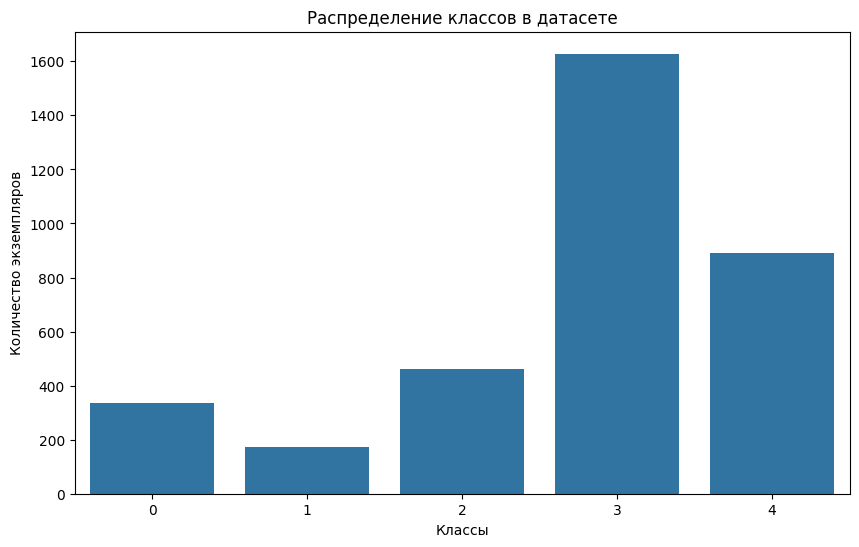

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Предположим, что ваши метки классов хранятся в списке image_labels
# image_labels = [0, 1, 2, 0, 1, 2, 0, 3, 4, ...]  # Пример меток классов

# Подсчет количества экземпляров каждого класса
unique_labels, counts = np.unique(image_labels, return_counts=True)

# Визуализация распределения
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=counts)
plt.title('Распределение классов в датасете')
plt.xlabel('Классы')
plt.ylabel('Количество экземпляров')
plt.xticks(unique_labels)  # Установка меток по оси X
plt.show()

In [18]:
import pandas as pd

# Предположим, у вас есть DataFrame df с колонкой 'label', где указаны классы
# df = pd.DataFrame({'label': image_labels})

# Определяем классы, которые нужно уменьшить
classes_to_reduce = [3, 4]

# Устанавливаем коэффициент уменьшения
reduction_factor = 1/3

# Создаем новый DataFrame для хранения сбалансированных данных
balanced_df = pd.DataFrame()

for class_label in classes_to_reduce:
    # Выбираем экземпляры текущего класса
    class_data = data[data['label'] == class_label]

    # Определяем количество экземпляров, которые нужно сохранить
    num_to_keep = int(len(class_data) * (1 - reduction_factor))

    # Случайным образом выбираем экземпляры для сохранения
    reduced_class_data = class_data.sample(num_to_keep, random_state=42)  # random_state для воспроизводимости

    # Добавляем уменьшенные данные в новый DataFrame
    balanced_df = pd.concat([balanced_df, reduced_class_data])

# Добавляем экземпляры из других классов без изменений
other_classes = data[~data['label'].isin(classes_to_reduce)]
balanced_df = pd.concat([balanced_df, other_classes])

# Перемешиваем итоговый DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверяем количество экземпляров в каждом классе
print(balanced_df['label'].value_counts())

label
4    1085
5     890
1     336
3     308
2     172
Name: count, dtype: int64


In [21]:
import pandas as pd

# Предположим, у вас есть DataFrame df с колонкой 'label', где указаны классы
# df = pd.DataFrame({'label': image_labels})

# Определяем классы, которые нужно уменьшить
classes_to_reduce = [4, 5]

# Устанавливаем коэффициент уменьшения
reduction_factor = 0.5  # Уменьшаем на 50%

# Создаем новый DataFrame для хранения сбалансированных данных
balanced_df = pd.DataFrame()

for class_label in classes_to_reduce:
    # Выбираем экземпляры текущего класса
    class_data = data[data['label'] == class_label]

    # Определяем количество экземпляров, которые нужно сохранить
    num_to_keep = int(len(class_data) * (1 - reduction_factor))

    # Случайным образом выбираем экземпляры для сохранения
    reduced_class_data = class_data.sample(num_to_keep, random_state=42)  # random_state для воспроизводимости

    # Добавляем уменьшенные данные в новый DataFrame
    balanced_df = pd.concat([balanced_df, reduced_class_data])

# Добавляем экземпляры из других классов без изменений
other_classes = data[~data['label'].isin(classes_to_reduce)]
balanced_df = pd.concat([balanced_df, other_classes])

# Перемешиваем итоговый DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверяем количество экземпляров в каждом классе
print(balanced_df['label'].value_counts())

label
4    814
3    463
5    445
1    336
2    172
Name: count, dtype: int64


In [22]:
images, image_labels = load_images_with_labels(balanced_df)

In [ ]:
print(image_labels)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Применяем преобразования к изображениям
images_tensor = []
for img_bytes in images:
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')  # Преобразуем байты в изображение PIL и конвертируем в RGB
    img_tensor = transform(img)  # Применяем трансформации
    images_tensor.append(img_tensor)

images_tensor = torch.stack(images_tensor)  # Преобразуем список в тензор
